In [49]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [30]:
# 데이터셋 인스턴스 생성
data = pd.read_csv('https://raw.githubusercontent.com/Kim-TaeWook/AI-class/refs/heads/main/week6/diabetes.csv')  # CSV 파일 경로

In [31]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [32]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

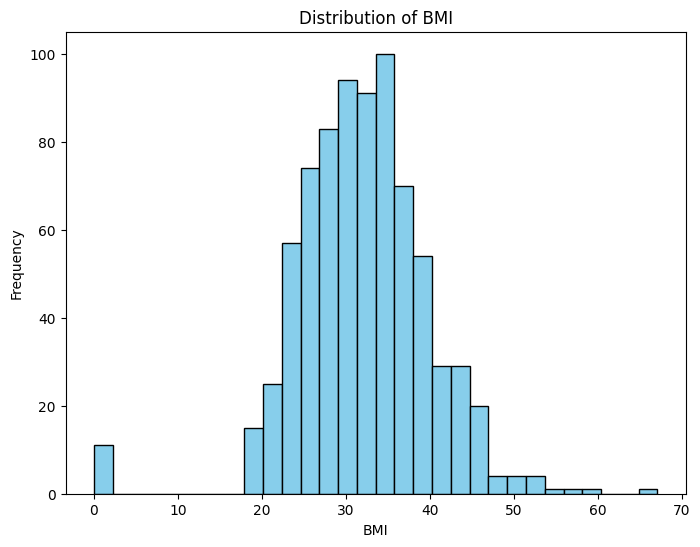

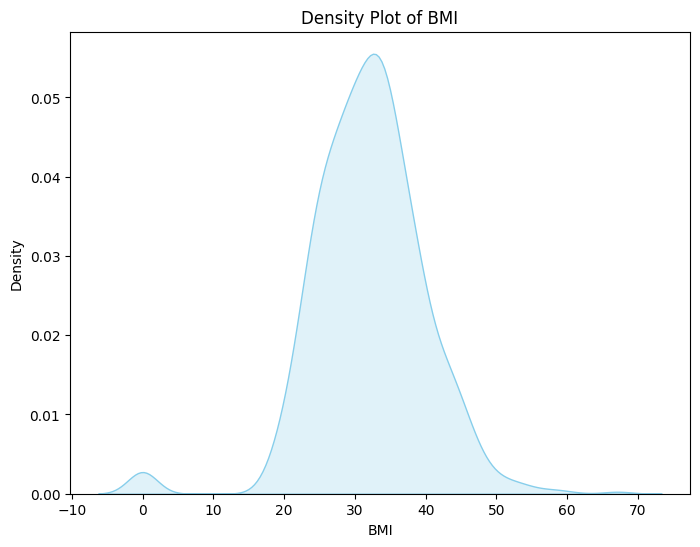

In [33]:
# Histogram 예시
plt.figure(figsize=(8, 6))
plt.hist(data["BMI"], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("Distribution of BMI")
plt.show()

# KDE plot 예시 (Seaborn 이용)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.kdeplot(data["BMI"], fill=True, color='skyblue')
plt.xlabel("BMI")
plt.ylabel("Density")
plt.title("Density Plot of BMI")
plt.show()

In [34]:
# 데이터와 타겟 분리
# 회귀 문제에서는 Outcome은 분류용이므로 타겟에서 제외하고,
# BMI를 타겟으로 사용합니다.
# 입력 특징은 BMI와 Outcome을 제외한 나머지 컬럼들입니다.
X = data.drop(['BMI', 'Outcome'], axis=1).values  # 예: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, DiabetesPedigreeFunction, Age
y = data['BMI'].values  # 타겟: BMI

In [35]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 선택 사항: 타겟(y) 스케일링도 가능 (예를 들어 MinMaxScaler 등), 
# 여기서는 BMI 원래 스케일로 예측하도록 유지합니다.

# 학습/테스트 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
print("Train shapes:", X_train.shape, y_train.shape)

Train shapes: (614, 7) (614,)


In [37]:
print("Test shapes:", X_test.shape, y_test.shape)

Test shapes: (154, 7) (154,)


In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 7), (154, 7), (614,), (154,))

In [39]:
# PyTorch 텐서 변환

# 텐서 변환: 회귀 문제이므로 y는 float 형으로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # (N, 1) 형태
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [40]:
# DataLoader 생
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 7]),
 torch.Size([154, 7]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

## **모델 정의**

In [42]:
# 회귀용 MLP 모델 정의
class DiabetesRegressionMLP(nn.Module):
    def __init__(self, input_dim):
        super(DiabetesRegressionMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)  # 회귀이므로 출력 1개
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # 출력: 예측한 BMI (연속형)
        return x

input_dim = X_train.shape[1]  # 여기서는 7개 특징
model = DiabetesRegressionMLP(input_dim)
print(model)

DiabetesRegressionMLP(
  (fc1): Linear(in_features=7, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


## **손실 함수 및 최적화 기법 정의**

In [43]:
# 손실 함수 및 최적화 설정 (회귀용: MSELoss 사용)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## **모델 학습**

In [44]:
# 학습 변수 초기화
num_epochs = []
train_losses = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training complete.")


Epoch 1/50, Loss: 1067.4018
Epoch 2/50, Loss: 1053.0322
Epoch 3/50, Loss: 1033.2524
Epoch 4/50, Loss: 1005.6928
Epoch 5/50, Loss: 968.6488
Epoch 6/50, Loss: 920.7593
Epoch 7/50, Loss: 861.0498
Epoch 8/50, Loss: 788.2165
Epoch 9/50, Loss: 703.2077
Epoch 10/50, Loss: 609.4722
Epoch 11/50, Loss: 510.6738
Epoch 12/50, Loss: 413.0973
Epoch 13/50, Loss: 322.3763
Epoch 14/50, Loss: 244.6994
Epoch 15/50, Loss: 185.2193
Epoch 16/50, Loss: 143.5433
Epoch 17/50, Loss: 116.2208
Epoch 18/50, Loss: 100.2541
Epoch 19/50, Loss: 91.3254
Epoch 20/50, Loss: 85.7427
Epoch 21/50, Loss: 82.1691
Epoch 22/50, Loss: 79.3310
Epoch 23/50, Loss: 77.2711
Epoch 24/50, Loss: 75.4422
Epoch 25/50, Loss: 73.8896
Epoch 26/50, Loss: 72.7331
Epoch 27/50, Loss: 71.4999
Epoch 28/50, Loss: 70.3782
Epoch 29/50, Loss: 69.2751
Epoch 30/50, Loss: 68.3321
Epoch 31/50, Loss: 67.4838
Epoch 32/50, Loss: 66.6504
Epoch 33/50, Loss: 65.8834
Epoch 34/50, Loss: 65.0370
Epoch 35/50, Loss: 64.3001
Epoch 36/50, Loss: 63.6167
Epoch 37/50, Lo

## **모델 평가**

In [50]:
# Evaluation
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_targets = np.array(all_targets).flatten()

mse = mean_squared_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)
print(f"Test MSE: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

Test MSE: 61.3097
Test R^2 Score: -0.0329


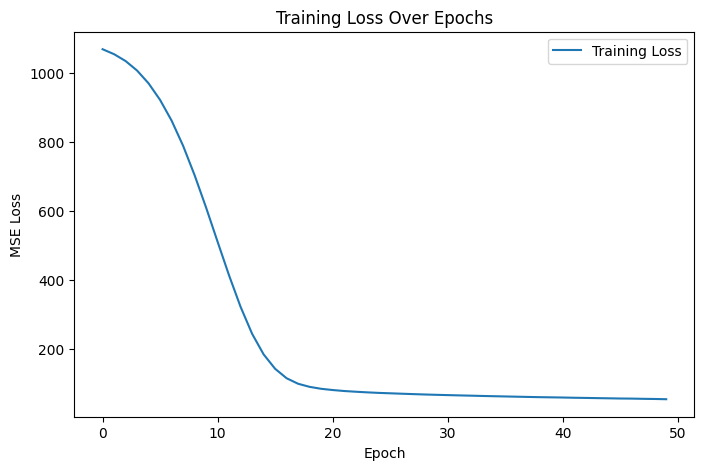

In [51]:
# Plot the loss and accuracy
plt.figure(figsize=(8, 5))

# Plot loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()